In [76]:
import numpy as np 
from matplotlib import pyplot as plt
import pandas 
import math

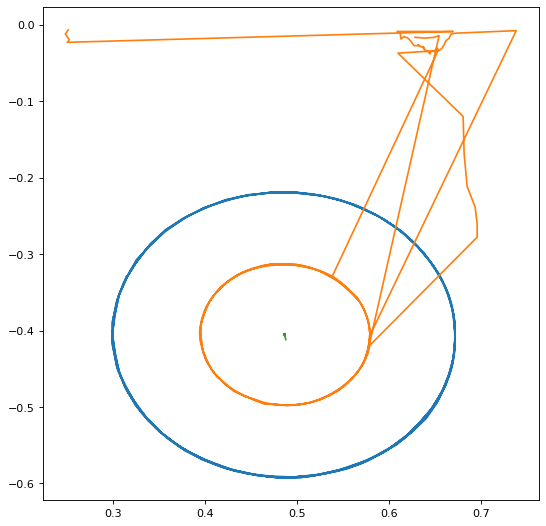

In [77]:
data = pandas.read_csv("L.csv")

data[["rx-hotpink", "ry-hotpink", "rx-lightorange", "ry-lightorange", "rx-green", "ry-green"]] /= 100

plt.figure(figsize=(8, 8), dpi=80)
plt.plot(data["rx-hotpink"], -1 * data["ry-hotpink"])
plt.plot(data["rx-lightorange"], -1 * data["ry-lightorange"])
plt.plot(data["rx-green"], -1 * data["ry-green"])
plt.title("Raw position path")

Raw positions plotted into one graph. Positions of light orange marker(the weight) is not consistent as tracking program was capturing incorrect possition when it was being dropped. 

Number of samples, before: 60 samples, after: 148 samples


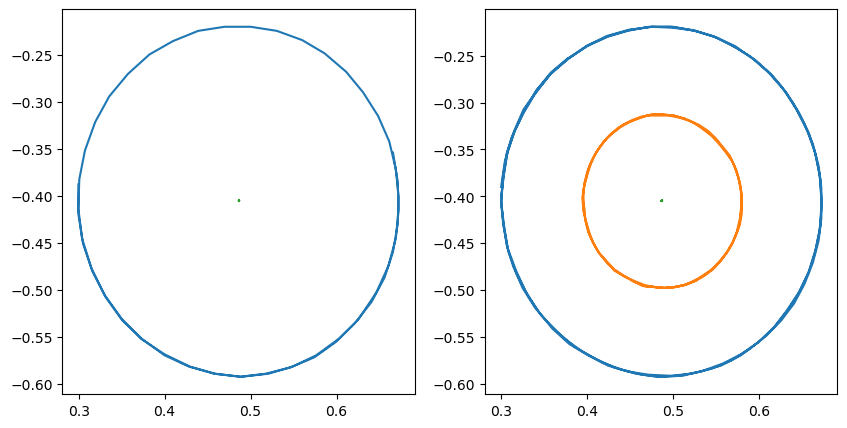

In [78]:
DROP_FRAME_AMOUNT=40
SAMPLE_FRAME_AMOUNT=60

weightDroppedFrame = data["rx-lightorange"].first_valid_index()

before = data[:weightDroppedFrame][-SAMPLE_FRAME_AMOUNT:].loc[:]
after = data[weightDroppedFrame + DROP_FRAME_AMOUNT:-DROP_FRAME_AMOUNT].loc[:]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].plot(before["rx-hotpink"], -1 * before["ry-hotpink"])
axs[0].plot(before["rx-lightorange"], -1 * before["ry-lightorange"])
axs[0].plot(before["rx-green"], -1 * before["ry-green"])
axs[0].set_title("Truncated position path before adding weight")
axs[1].plot(after["rx-hotpink"], -1 * after["ry-hotpink"])
axs[1].plot(after["rx-lightorange"], -1 * after["ry-lightorange"])
axs[1].plot(after["rx-green"], -1 * after["ry-green"])
axs[1].set_title("Truncated position path after adding weight")

Nice and clean now!

Now find center, interia of mass, and more

Intertia before 0.00097
Intertia after 0.0011419965578813671
Avg angular velocity before:  6.407449982965062 . uncertainty:  0.3969701001641433
Avg angular velocity after:  4.060662020608665 . uncertainty:  0.03651575039462736
Avg angular momentum before:  0.00621522648347611 . uncertainty:  0.000385060997159219
Avg angular momentum after:  0.00463708159095187 . uncertainty:  4.1700158346594446e-05



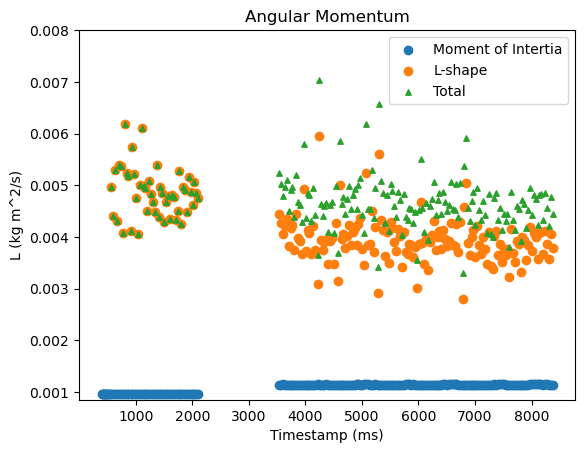

In [79]:
def distance(a, b):
    return math.sqrt(np.sum(np.square(np.array(a) - np.array(b))))

def uncertainty(a):
    return np.std(a) / math.sqrt(len(a))

I_l = 9.7 * 10 ** -4
m_weight = 20 / 1000

center = np.average(data["rx-green"].dropna()), np.average(data["ry-green"].dropna())
center_x, center_y = np.average(data["rx-green"].dropna()), np.average(data["ry-green"].dropna())

before["r_l"] = np.sqrt((before["rx-hotpink"] - center_x) ** 2 + (before["ry-hotpink"] - center_y) ** 2)
before["I"] = I_l
after["r_l"] = np.sqrt((after["rx-hotpink"] - center_x) ** 2 + (after["ry-hotpink"] - center_y) ** 2)
after["r_weight"] = np.sqrt((after["rx-lightorange"] - center_x) ** 2 + (after["ry-lightorange"] - center_y) ** 2)
after["I_weight"] = m_weight * after["r_weight"] ** 2 + 1.32 * 10 ** -6
after["I"] = after["I_weight"] + I_l

print("Intertia before", np.average(before["I"].dropna()))
print("Intertia after", np.average(after["I"].dropna()))

diff_after = after.diff().fillna(1)
diff_before = before.diff().fillna(1)

before["v_tan"] = np.sqrt(diff_before["rx-hotpink"] ** 2 + diff_before["ry-hotpink"] ** 2) / diff_before["timestamp"] * 1000
before["w"] = before["v_tan"] / before["r_l"]
after["v_tan"] = np.sqrt(diff_after["rx-hotpink"] ** 2 + diff_after["ry-hotpink"] ** 2) / diff_after["timestamp"] * 1000
after["w"] = after["v_tan"] / after["r_l"]
after["L"] = after["w"] * after["I"]
before["L"] = before["w"] * before["I"]

before, after = before.iloc[1:-1] , after.iloc[1:-1]

w_before, w_before_uncert = np.average(before["w"].dropna()), uncertainty(before["w"].dropna())
w_after, w_after_uncert = np.average(after["w"].dropna()), uncertainty(after["w"].dropna())

print("Avg angular velocity before: ", w_before, ". uncertainty: ", uncertainty(before["w"].dropna()))
print("Avg angular velocity after: ", w_after, ". uncertainty: ", uncertainty(after["w"].dropna()))

print("Avg angular momentum before: ", np.average(before["L"]), ". uncertainty: ", w_before_uncert * np.average(before["I"]))
print("Avg angular momentum after: ", np.average(after["L"]), ". uncertainty: ", w_after_uncert * np.average(after["I"]))


total = pandas.concat([before, after])
total["L"] = total["w"] * total["I"]

fig, ax = plt.subplots()

ax.scatter(total["timestamp"], total["I"], label="Moment of Intertia")

ax.scatter(total["timestamp"], total["w"] * I_l, label="L-shape")
ax.scatter(total["timestamp"], total["L"], label="Total", marker="^", s=15)

ax.set_ylim([0.00085, 0.008])
ax.set_title("Angular Momentum")
ax.set_ylabel("L (kg m^2/s)")
ax.set_xlabel("Timestamp (ms)")
plt.legend()

print()